In [5]:
import numpy as np
import pandas as pd
import imageio.v2 as imageio
from imageio import imread
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import keras.backend as K
from keras.losses import binary_crossentropy
import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation, Dropout, Concatenate
from keras.layers import GlobalAveragePooling2D, UpSampling2D, Conv2D, MaxPooling2D


In [6]:
df = pd.read_csv('train_ship_segmentations_v2.csv')
print(df.shape)
df.head()

(231723, 2)


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


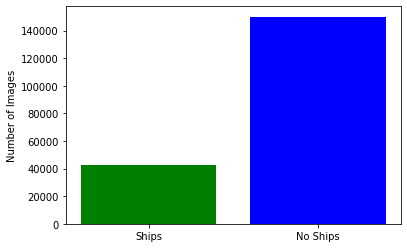

In [7]:
# Data balance checking
ships = df[~df.EncodedPixels.isna()].ImageId.unique()
noships = df[df.EncodedPixels.isna()].ImageId.unique()

plt.bar(['Ships', 'No Ships'], [len(ships), len(noships)], color=['green', 'blue']);
plt.ylabel('Number of Images');

In [8]:
# Delete missing values
masks = df.drop(df[df['EncodedPixels'].isnull()].sample(70000,random_state=42).index)

In [9]:
masks.shape

(161723, 2)

In [10]:
# Grouping by the number of ships that belong to one picture
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='Counts')

# Split into training and validation groups
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.2, 
                 stratify = unique_img_ids['Counts'],
                 random_state=42)


# Merge of samples, one image can correspond to several lines
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0],  'training masks')
print(valid_df.shape[0],  'validation masks')

129373 training masks
32350 validation masks


In [11]:
train_df.head()

,ImageId,EncodedPixels,Counts
0,0001124c7.jpg,NaN,1
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
2,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
3,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,5
4,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,5


In [12]:
valid_df.head()

,ImageId,EncodedPixels,Counts
0,0001b1832.jpg,NaN,1
1,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,2
2,0002756f7.jpg,248878 1 249645 4 250413 6 251180 9 251948 10 ...,2
3,00053c6ba.jpg,565382 3 566144 9 566909 12 567677 13 568445 1...,1
4,000a4d4fd.jpg,NaN,1


In [13]:
# Replace NaN with zero
train_df['Counts'] = train_df.apply(lambda c_row: c_row['Counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)
valid_df['Counts'] = valid_df.apply(lambda c_row: c_row['Counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)

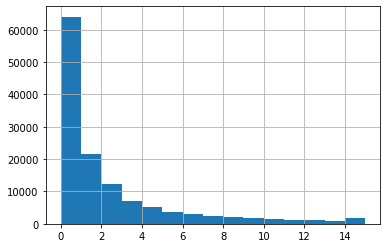

In [14]:
# The ratio of the num of ships in sample
train_df['Counts'].hist(bins=15);

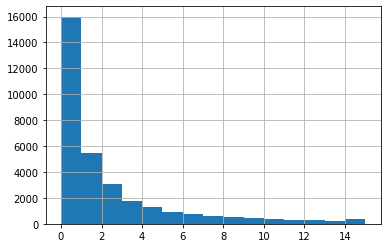

In [15]:
valid_df['Counts'].hist(bins=15);

In [16]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

C:\Users\dzyub\AppData\Local\Temp\ipykernel_19044\2660863990.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('../new/train_v2/' + ImageId)


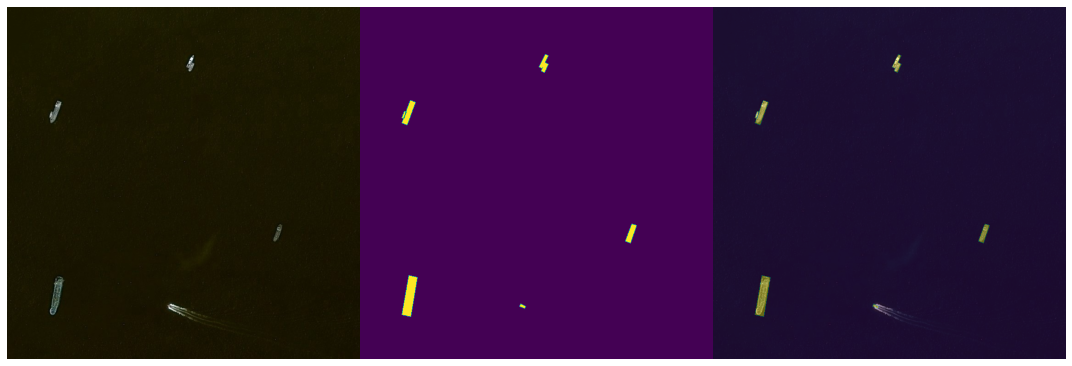

In [17]:
# Example
ImageId = '194a2b8c9.jpg'

img = imread('../new/train_v2/' + ImageId)
img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img[...,[2,1,0]]) #rgb
axarr[1].imshow(all_masks, cmap='viridis')
axarr[2].imshow(img, cmap='viridis')
axarr[2].imshow(all_masks, alpha=0.4, cmap='viridis')
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [18]:
# Make a generator to produce batches of images
IMG_SCALING = (1,1)

def keras_generator(gen_df, batch_size=4):
    all_batches = list(gen_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join('../new/train_v2', c_img_id)
            c_img = cv2.imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [19]:
# Checking the dimension
train_gen = keras_generator(train_df,5)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.dtype, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.dtype, train_y.min(), train_y.max())

x (5, 768, 768, 3) float64 0.0 0.9607843137254902
y (5, 768, 768, 1) int16 0 1


In [21]:
# Building Unet model
inp = Input(shape=(768, 768, 3))

# first block
conv_1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
conv_1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_1_1)
pool_1 = MaxPooling2D(2)(conv_1_2)


# second block
conv_2_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool_1)
conv_2_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_2_1)
pool_2 = MaxPooling2D(2)(conv_2_2)


# third block
conv_3_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool_2)
conv_3_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_3_1)
pool_3 = MaxPooling2D(2)(conv_3_2)


# fourth block
conv_4_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool_3)
conv_4_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_4_1)
pool_4 = MaxPooling2D(2)(conv_4_2)


# fifth block
conv_5_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool_4)
conv_5_2 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv_5_1)
pool_5 = MaxPooling2D(2)(conv_5_2)


# first decoding block
up_1 = UpSampling2D(2, interpolation='bilinear')(pool_5)
conc_1 = Concatenate()([conv_5_2, up_1])
conv_up_1_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(conc_1)
conv_up_1_2 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv_up_1_1)

# second decoding block
up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_4_2, up_2])
conv_up_2_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc_2)
conv_up_2_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_up_2_1)


# third decodinc block
up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_3_2, up_3])
conv_up_3_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc_3)
conv_up_3_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_up_3_1)

# fourth decoding block
up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_2_2, up_4])
conv_up_4_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc_4)
conv_up_4_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_up_4_1)

# fifth decoding block
up_5 = UpSampling2D(2, interpolation='bilinear')(conv_up_4_2)
conc_5 = Concatenate()([conv_1_2, up_5])
conv_up_5_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc_5)
conv_up_5_2 = Conv2D(1, (3, 3), padding='same')(conv_up_5_1)
result = Activation('sigmoid')(conv_up_5_2)


unet_model = Model(inputs=inp, outputs=result)

unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 768, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 768, 768, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 768, 768, 32  9248        ['conv2d_20[0][0]']              
                                )                                                           

 conv2d_37 (Conv2D)             (None, 384, 384, 64  36928       ['conv2d_36[0][0]']              
                                )                                                                 
                                                                                                  
 up_sampling2d_9 (UpSampling2D)  (None, 768, 768, 64  0          ['conv2d_37[0][0]']              
                                )                                                                 
                                                                                                  
 concatenate_9 (Concatenate)    (None, 768, 768, 96  0           ['conv2d_21[0][0]',              
                                )                                 'up_sampling2d_9[0][0]']        
                                                                                                  
 conv2d_38 (Conv2D)             (None, 768, 768, 32  27680       ['concatenate_9[0][0]']          
          

In [22]:
# Callbacks
best_w = keras.callbacks.ModelCheckpoint('best_unet.w',
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=True,
                                        save_weights_only=True,
                                        mode='auto',
                                        patience=1)

last_w = keras.callbacks.ModelCheckpoint('last_unet.w',
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=False,
                                        save_weights_only=True,
                                        mode='auto',
                                        patience=20)

callbacks = [best_w, last_w]

In [23]:
# IoU of boats
def IoU(y_true, y_pred, eps=1e-6):
    y_true=K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return K.mean( (intersection + eps) / (union + eps), axis=0)

# IoU of non-boats
def zero_IoU(y_true, y_pred):
    return IoU(1-y_true, 1-y_pred)

def agg_loss(in_gt, in_pred):
    return -1e-2 * zero_IoU(in_gt, in_pred) - IoU(in_gt, in_pred)

# Optimizer
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)  
  
unet_model.compile(optimizer=adam, loss=agg_loss, metrics=[IoU, zero_IoU, 'binary_accuracy'])

In [24]:
loss_history = [unet_model.fit_generator(keras_generator(train_df),
                                        steps_per_epoch=100, 
                                        epochs=5, 
                                        validation_data=keras_generator(valid_df),
                                        validation_steps=50,
                                        callbacks=callbacks)]

C:\Users\dzyub\AppData\Local\Temp\ipykernel_19044\2701730995.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = [unet_model.fit_generator(keras_generator(train_df),


Epoch 1/5
100/100 [==============================] - 2409s 24s/step - loss: -0.5773 - IoU: 0.5676 - zero_IoU: 0.9745 - binary_accuracy: 0.9983 - val_loss: -0.6850 - val_IoU: 0.6750 - val_zero_IoU: 0.9982 - val_binary_accuracy: 0.9982
Epoch 2/5
100/100 [==============================] - 2191s 22s/step - loss: -0.6325 - IoU: 0.6225 - zero_IoU: 0.9979 - binary_accuracy: 0.9979 - val_loss: -0.7350 - val_IoU: 0.7250 - val_zero_IoU: 0.9992 - val_binary_accuracy: 0.9992
Epoch 3/5
100/100 [==============================] - 1510s 15s/step - loss: -0.6400 - IoU: 0.6300 - zero_IoU: 0.9981 - binary_accuracy: 0.9981 - val_loss: -0.6800 - val_IoU: 0.6700 - val_zero_IoU: 0.9985 - val_binary_accuracy: 0.9985
Epoch 4/5
100/100 [==============================] - 1513s 15s/step - loss: -0.7250 - IoU: 0.7150 - zero_IoU: 0.9988 - binary_accuracy: 0.9988 - val_loss: -0.6900 - val_IoU: 0.6800 - val_zero_IoU: 0.9978 - val_binary_accuracy: 0.9978
Epoch 5/5
100/100 [==============================] - 1510s 15s/s

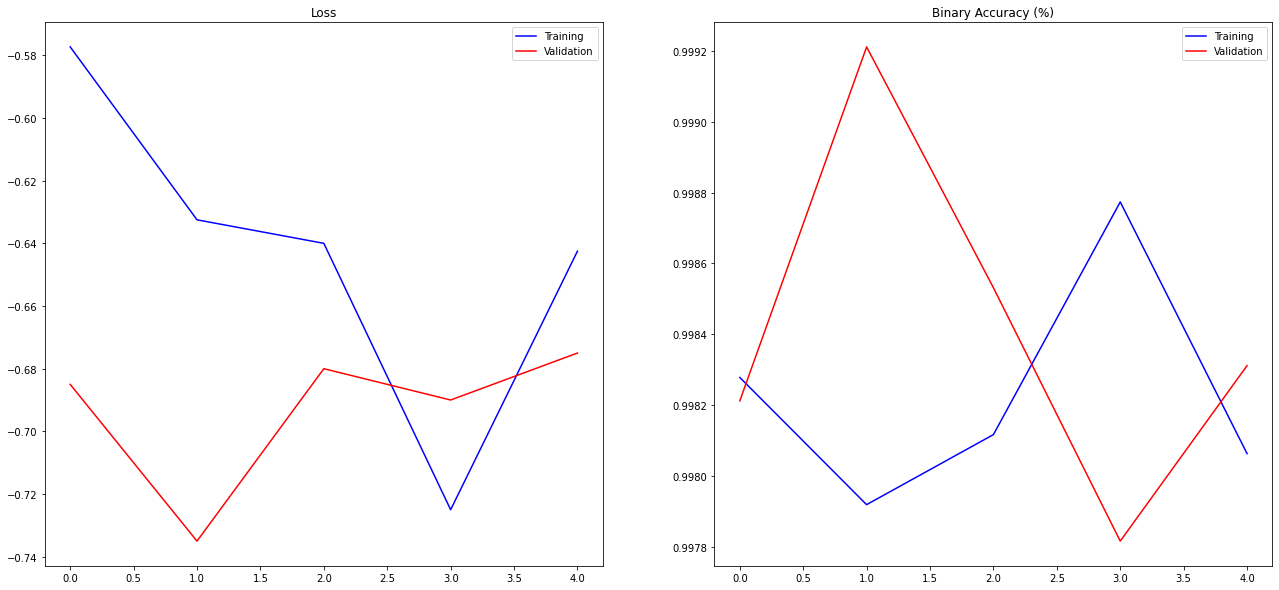

In [25]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')

show_loss(loss_history)